<a href="https://colab.research.google.com/github/heeyoung00/Most-Streamed-Songs_analysis/blob/main/%EC%B6%94%EA%B0%80%20%EB%B6%84%EC%84%9D%EC%A7%84%ED%96%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import shap
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 전처리 데이터.csv to 전처리 데이터 (2).csv


In [ ]:
data = pd.read_csv('전처리 데이터.csv')

In [ ]:
spring =data[data['season'] == 'spring']
summer =data[data['season'] == 'summer']
autumn =data[data['season'] == 'autumn']
winter =data[data['season'] == 'winter']

다항회귀

Mean Squared Error (MSE): 0.0466
R-squared (R²): -0.0733
                               Coefficient
bpm                               0.016319
danceability_%                    0.017274
acousticness_%                    0.023488
valence_%                         0.003742
energy_%                         -0.007521
bpm^2                             0.006316
bpm danceability_%               -0.010476
bpm acousticness_%                0.005801
bpm valence_%                     0.002760
bpm energy_%                      0.004502
danceability_%^2                 -0.011617
danceability_% acousticness_%     0.025038
danceability_% valence_%          0.037327
danceability_% energy_%           0.008080
acousticness_%^2                  0.013936
acousticness_% valence_%         -0.013860
acousticness_% energy_%           0.040522
valence_%^2                      -0.021479
valence_% energy_%               -0.010851
energy_%^2                        0.012003


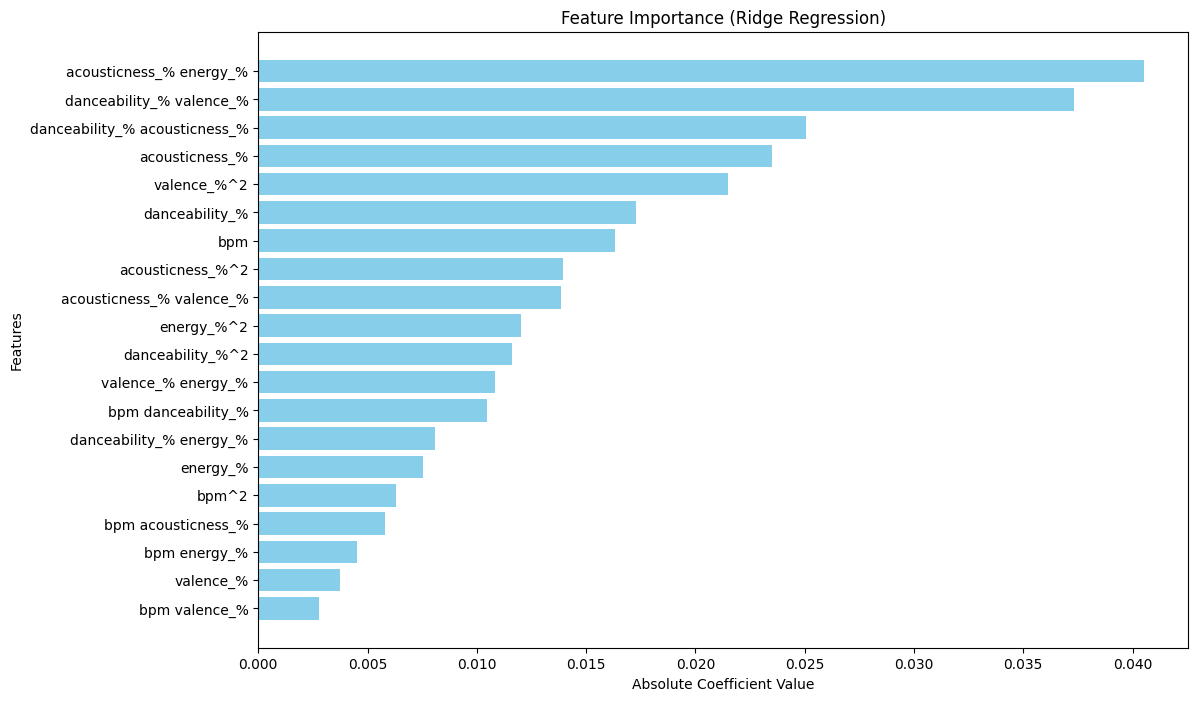

In [ ]:
# 독립 변수와 종속 변수 설정
X = data[['bpm', 'danceability_%', 'acousticness_%','valence_%','energy_%']]
y = data['chart_score']

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 다항 특성 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ridge 회귀 모델 학습
ridge_model = Ridge(alpha=1.0)  # alpha는 규제 강도를 조절 (기본값: 1.0)
ridge_model.fit(X_train, y_train)

# 예측
y_pred =ridge_model.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# 회귀 계수 분석
coefficients = pd.DataFrame(ridge_model.coef_, poly.get_feature_names_out(['bpm', 'danceability_%', 'acousticness_%','valence_%','energy_%']), columns=['Coefficient'])
print(coefficients)

# 변수 중요도 계산 및 시각화
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(coefficients.index, coefficients['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance (Ridge Regression)')
plt.gca().invert_yaxis()  # Y축을 뒤집어 상위 항목이 위에 오도록 설정
plt.show()

gradient boost - 비선형 회귀에 사용

shap 을 통해 시각화

Gradient Boosting Mean Squared Error (MSE): 0.0524
Gradient Boosting R-squared (R²): -0.2073


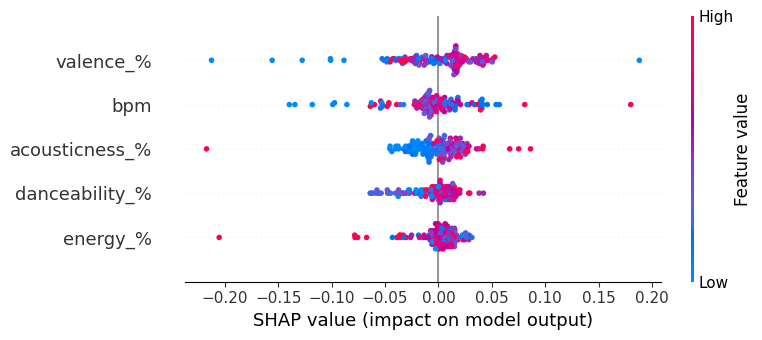

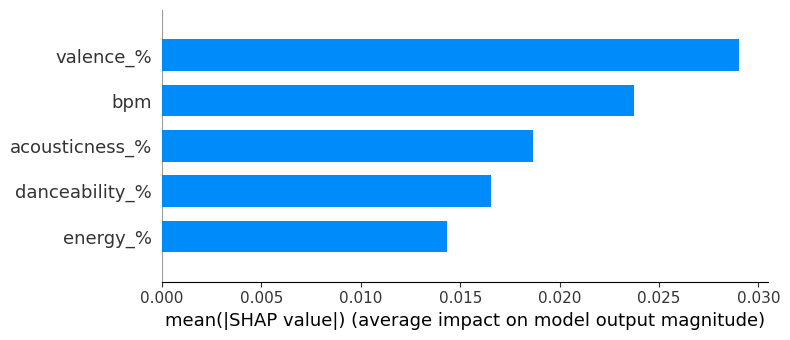

In [ ]:
X = data[['bpm', 'danceability_%', 'acousticness_%', 'energy_%', 'valence_%']]
y = data['chart_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import necessary packages for Gradient Boosting and SHAP analysis
import shap
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(
    random_state=42,  # 결과 재현성을 위한 시드 설정
)
gbr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate the model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# Print performance metrics
print(f"Gradient Boosting Mean Squared Error (MSE): {mse_gbr:.4f}")
print(f"Gradient Boosting R-squared (R²): {r2_gbr:.4f}")

# SHAP analysis
explainer = shap.Explainer(gbr_model, X_train)
shap_values = explainer(X_test)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test)

# Feature importance from SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")


## x축으로 퍼져있을수록 변수가 y값에 크게 영향을 주는 것을 의미
## y축으로 높을수록 영향이 큼

Random Forest

Random Forest Mean Squared Error (MSE): 0.0507
Random Forest R-squared (R²): -0.1695


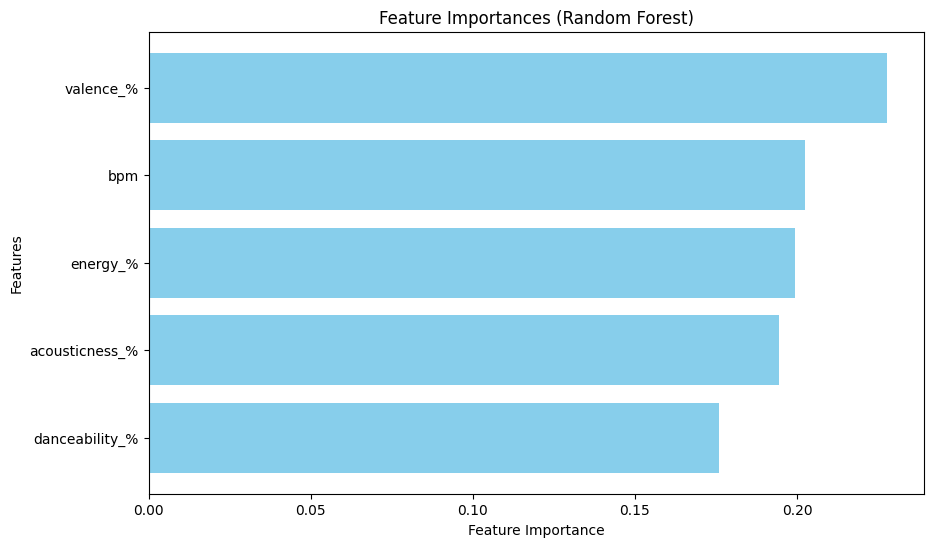

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Select independent and dependent variables
X = data[['bpm', 'danceability_%', 'acousticness_%', 'energy_%', 'valence_%']]
y = data['chart_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print performance metrics
print(f"Random Forest Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Random Forest R-squared (R²): {r2_rf:.4f}")

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # Reverse the y-axis for better readability
plt.show()

chart_ score 상위 30% 하위 30% 분류

<Figure size 1000x600 with 0 Axes>

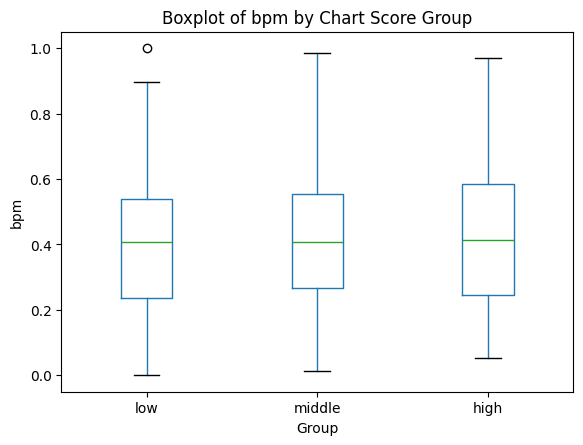

<Figure size 1000x600 with 0 Axes>

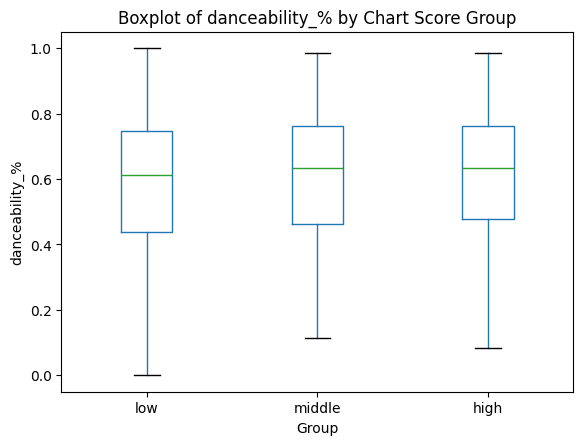

<Figure size 1000x600 with 0 Axes>

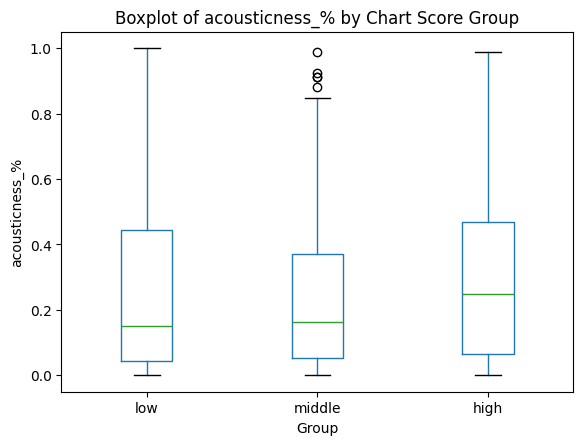

<Figure size 1000x600 with 0 Axes>

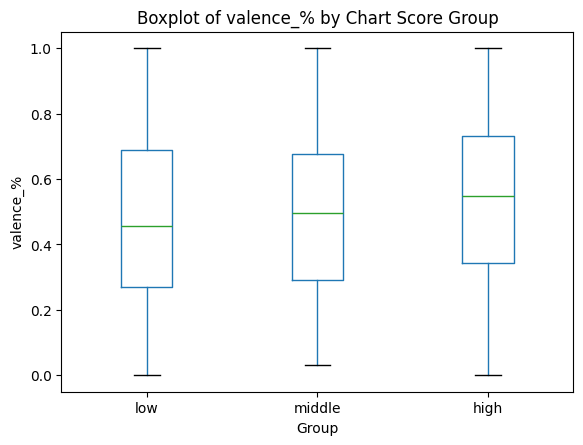

<Figure size 1000x600 with 0 Axes>

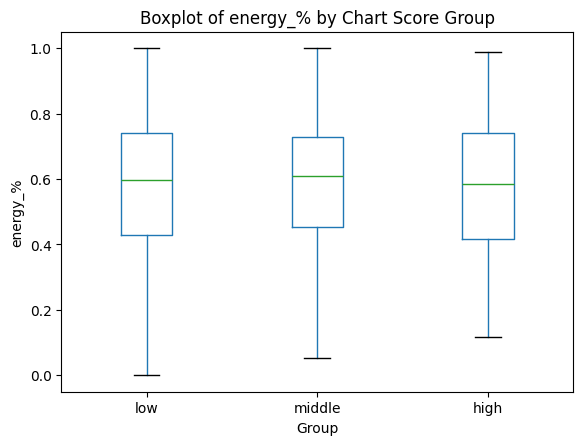

In [ ]:
# Define thresholds for 'high', 'middle', 'low' based on chart_score
high_threshold = data['chart_score'].quantile(0.7)
low_threshold = data['chart_score'].quantile(0.3)

# Create a new column for category labels
data['group'] = pd.cut(
    data['chart_score'],
    bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
    labels=['low', 'middle', 'high']
)

# Define features to compare across groups
features = ['bpm', 'danceability_%', 'acousticness_%', 'valence_%', 'energy_%']

# Plot boxplots for each feature across 'low', 'middle', 'high' groups
for feature in features:
    plt.figure(figsize=(10, 6))
    data.boxplot(column=feature, by='group', grid=False)
    plt.title(f'Boxplot of {feature} by Chart Score Group')
    plt.suptitle('')  # Remove default subtitle
    plt.xlabel('Group')
    plt.ylabel(feature)
    plt.show()

gradient 결과의 높은 영향을 주는 bpm, valence의
박스플롯을 보면 valence와 bpm은 high 그룹의 박스가 조금 올라가있는 반면
dancability나 energy는 크게 차이가 없다.
- bpm, valence 가 높으면 차트 점수가 높을 가능성이 있다.

계절별 변수 중요도

Spring Season:
  Mean Squared Error (MSE): 0.0530
  R-squared (R²): -0.2292
Summer Season:
  Mean Squared Error (MSE): 0.0546
  R-squared (R²): -0.1247
Autumn Season:
  Mean Squared Error (MSE): 0.0588
  R-squared (R²): -0.7579
Winter Season:
  Mean Squared Error (MSE): 0.0405
  R-squared (R²): -0.0374

Spring Season SHAP Summary Plot:


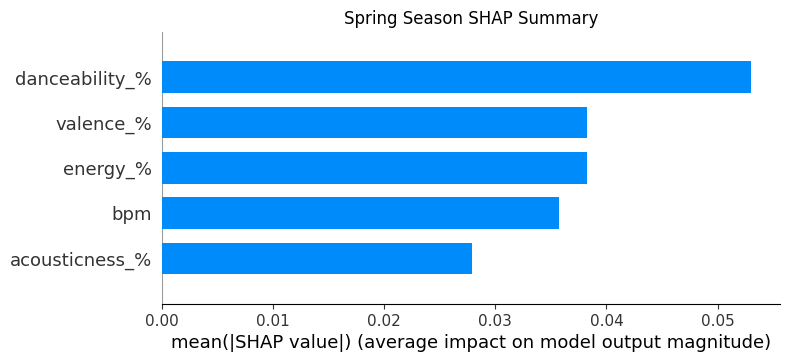


Summer Season SHAP Summary Plot:


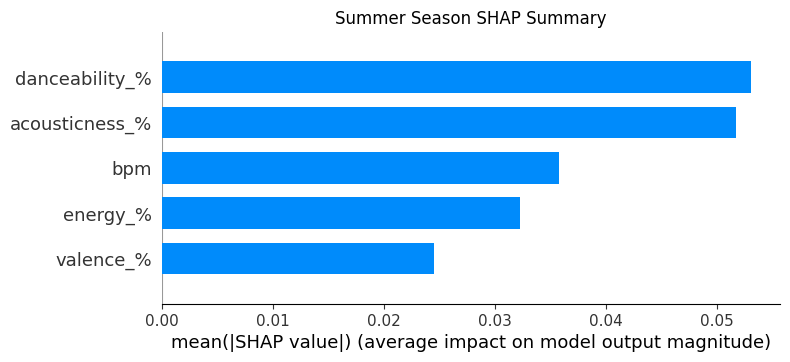


Autumn Season SHAP Summary Plot:


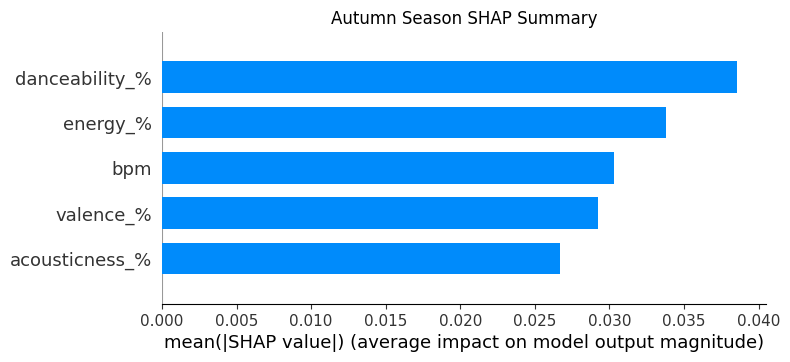


Winter Season SHAP Summary Plot:


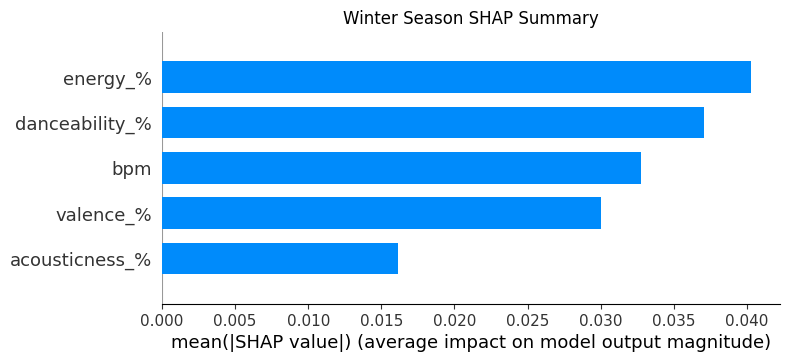

In [ ]:
import matplotlib.pyplot as plt

# Function to train model and perform SHAP analysis for each season
def analyze_season(data, season_name):
    X = data[['bpm', 'danceability_%', 'acousticness_%', 'energy_%', 'valence_%']]
    y = data['chart_score']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Gradient Boosting Regressor
    gbr_model = GradientBoostingRegressor(random_state=42)
    gbr_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_gbr = gbr_model.predict(X_test)

    # Evaluate the model
    mse_gbr = mean_squared_error(y_test, y_pred_gbr)
    r2_gbr = r2_score(y_test, y_pred_gbr)

    # Print performance metrics
    print(f"{season_name.capitalize()} Season:")
    print(f"  Mean Squared Error (MSE): {mse_gbr:.4f}")
    print(f"  R-squared (R²): {r2_gbr:.4f}")

    # SHAP analysis
    explainer = shap.Explainer(gbr_model, X_train)
    shap_values = explainer(X_test, check_additivity=False)

    # Return SHAP values and test set for visualization
    return shap_values, X_test

# Define seasons
seasons = {
    'spring': data[data['season'] == 'spring'],
    'summer': data[data['season'] == 'summer'],
    'autumn': data[data['season'] == 'autumn'],
    'winter': data[data['season'] == 'winter'],
}

# Analyze each season and store results
results = {season: analyze_season(season_data, season) for season, season_data in seasons.items()}

# Plot SHAP summary for each season
for season, (shap_values, X_test) in results.items():
    print(f"\n{season.capitalize()} Season SHAP Summary Plot:")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f"{season.capitalize()} Season SHAP Summary")
    plt.show()

여름에 acoustic 영향도 증가
겨울에 energy 영향도 증가